In [4]:
%matplotlib inline
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import torch
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression

warnings.filterwarnings('ignore')

In [5]:
train_logs = pd.read_csv('input/train_logs.csv')
train_scores = pd.read_csv('input/train_scores.csv')
train_essays = pd.read_csv('output/essays.csv')

In [6]:
train_essays.index = train_essays["id"]
train_essays.index.name = None
train_essays.drop(columns=["Unnamed: 0", "score", "id"], inplace=True)
train_essays.head(2)

,essay
001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."


In [7]:
# Helper functions

def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [8]:
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', pd.Series.kurtosis, 'sum']

def split_essays_into_sentences(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    essay_df = essay_df.explode('sent')
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split()))
    essay_df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
    return essay_df

def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def split_essays_into_paragraphs(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
    essay_df = essay_df.explode('paragraph')
    # Number of characters in paragraphs
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split()))
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

In [9]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essays)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
train_sent_agg_df.head(2)

,sent_count,sent_len_mean,sent_len_std,sent_len_min,sent_len_max,sent_len_first,sent_len_last,sent_len_sem,sent_len_q1,sent_len_median,...,sent_word_count_first,sent_word_count_last,sent_word_count_sem,sent_word_count_q1,sent_word_count_median,sent_word_count_q3,sent_word_count_skew,sent_word_count_kurt,sent_word_count_sum,id
0,14,106.428571,63.318140,1,245,31,1,16.922485,68.0,114.0,...,6,1,2.838953,11.0,20.0,23.5,0.600225,1.033058,256,001519c8
1,15,107.666667,64.713287,19,226,19,143,16.708899,56.5,92.0,...,3,30,3.303485,11.0,20.0,31.0,0.383876,-0.975827,323,0022f953


In [10]:
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)
train_paragraph_agg_df.head(2)

,paragraph_count,paragraph_len_mean,paragraph_len_std,paragraph_len_min,paragraph_len_max,paragraph_len_first,paragraph_len_last,paragraph_len_sem,paragraph_len_q1,paragraph_len_median,...,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum,id
0,3,509.333333,120.022220,404,640,404,484,69.294861,444.00,484.0,...,70,81,10.333333,75.5,81.0,93.00,1.025649,NaN,256,001519c8
1,6,278.166667,98.554384,176,462,240,284,40.234659,228.75,261.0,...,52,55,8.441959,43.0,53.5,57.25,0.961670,1.823927,324,0022f953


In [11]:
from collections import defaultdict

class Preprocessor:
    
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        
        self.idf = defaultdict(float)
    
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols
        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    def make_feats(self, df):
        
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        
        print("Engineering time data")
        for gap in self.gaps:
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering cursor position data")
        for gap in self.gaps:
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering word count data")
        for gap in self.gaps:
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        print("Engineering statistical summaries for features")
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.Series.kurtosis]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.Series.kurtosis]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.Series.kurtosis]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.Series.kurtosis])
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']

        return feats

In [12]:
preprocessor = Preprocessor(seed=0)
train_feats = preprocessor.make_feats(train_logs)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [07:48<00:00, 14.20s/it, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 3840.84it/s]


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 3607.61it/s]


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 4040.39it/s]


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 3902.89it/s]


Engineering input words data
Engineering ratios data


In [13]:
# Code for additional aggregations comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs

train_agg_fe_df = train_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')

In [14]:
# Code for creating these features comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

data = []

for logs in [train_logs]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674 = data[0]

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [15]:
train_feats = train_feats.merge(train_sent_agg_df, on='id', how='left')
train_feats = train_feats.merge(train_paragraph_agg_df, on='id', how='left')

In [16]:
target_col = ['score', 'score_x', 'score_y']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [17]:
from sklearn.model_selection import train_test_split

X, y = train_feats[train_cols].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(0), train_scores['score']
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', str(ord(x[0])), x))
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=.25, random_state=0)
def round_scores(scores):
    scores = ((scores * 2.1) // 1) * .5
    scores = np.where(scores < 0, 0.0, scores)
    scores = np.where(scores > 6, 6.0, scores)
    return scores

MAE: training set
0.5856182356695512
MAE: validation set
0.6703675950928769


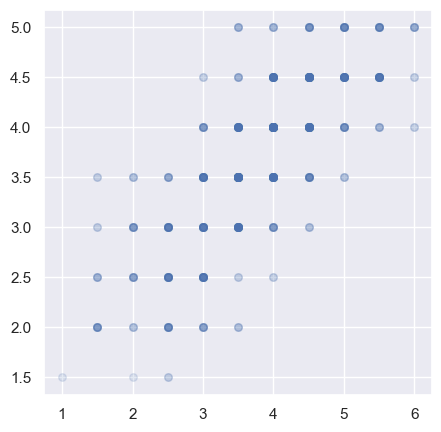

In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set()

model = GradientBoostingRegressor(max_depth=2, min_samples_leaf=4, n_estimators=50, learning_rate=.1, subsample=.5)
model.fit(X_train, y_train)
y_predict_train = round_scores(model.predict(X_train))
y_predict_valid = round_scores(model.predict(X_valid))
print('MAE: training set')
print(mean_squared_error(y_train, y_predict_train, squared=False))
print('MAE: validation set')
print(mean_squared_error(y_valid, y_predict_valid, squared=False))
plt.figure(figsize=(5,5))
plt.scatter(y_valid, y_predict_valid, s=30, alpha=.15);

In [19]:
train = train_feats[train_cols].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(0)
train_scores['score']

data = pd.DataFrame()
data['features'] = train_cols
data['VIF'] = [variance_inflation_factor(train, i).round(1) for i in range(train.shape[1])]
f_scores, p_scores = f_regression(train, train_scores['score'])
data['Fscores'] = f_scores.round(0)
data['Pscores'] = p_scores.round(5)
data = data.sort_values(by='Fscores', ascending=False)
best_feats = data['features'].values

MAE: training set
0.4510446713426052
MAE: validation set
0.6845607948030449


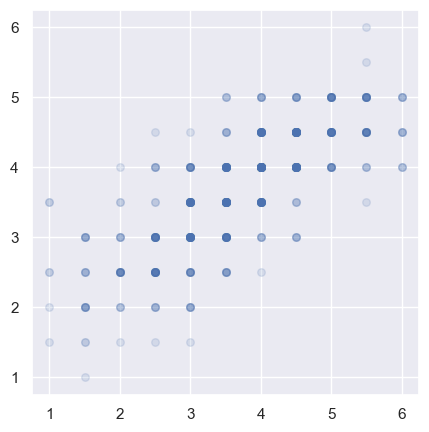

In [20]:
X, y = train_feats[best_feats].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(0), train_scores['score']
X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=.2, random_state=100)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=.25, random_state=100)

model = GradientBoostingRegressor(max_depth=2, min_samples_leaf=5, n_estimators=200, learning_rate=.1, subsample=.5)
model.fit(X_train, y_train)
y_predict_train = round_scores(model.predict(X_train))
y_predict_valid = round_scores(model.predict(X_valid))
print('MAE: training set')
print(mean_squared_error(y_train, y_predict_train, squared=False))
print('MAE: validation set')
print(mean_squared_error(y_valid, y_predict_valid, squared=False))
plt.figure(figsize=(5,5))
plt.scatter(y_valid, y_predict_valid, s=30, alpha=.15);

In [21]:
OOF_PREDS = np.zeros((len(train_feats), 2))

In [22]:
# Code comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
train_feats['score'] = train_scores['score']
models_dict = {}
scores = []

test_predict_list = []
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.04,   #0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18,
               'n_jobs':4
              }

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][best_feats], train_feats.iloc[train_idx]['score']
        X_valid, y_valid = train_feats.iloc[valid_idx][best_feats], train_feats.iloc[valid_idx]['score']
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )
        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        OOF_PREDS[valid_idx, 0] += valid_predict / 5
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats['score'], oof_valid_preds, squared=False)
    scores.append(oof_score)
scores

[1]	valid_0's rmse: 0.996026
[2]	valid_0's rmse: 0.974717
[3]	valid_0's rmse: 0.953879
[4]	valid_0's rmse: 0.933045
[5]	valid_0's rmse: 0.913879
[6]	valid_0's rmse: 0.897155
[7]	valid_0's rmse: 0.881061
[8]	valid_0's rmse: 0.865433
[9]	valid_0's rmse: 0.850542
[10]	valid_0's rmse: 0.835905
[11]	valid_0's rmse: 0.822422
[12]	valid_0's rmse: 0.809993
[13]	valid_0's rmse: 0.798368
[14]	valid_0's rmse: 0.786029
[15]	valid_0's rmse: 0.775713
[16]	valid_0's rmse: 0.765929
[17]	valid_0's rmse: 0.75691
[18]	valid_0's rmse: 0.747444
[19]	valid_0's rmse: 0.739584
[20]	valid_0's rmse: 0.731372
[21]	valid_0's rmse: 0.724074
[22]	valid_0's rmse: 0.717718
[23]	valid_0's rmse: 0.710998
[24]	valid_0's rmse: 0.705132
[25]	valid_0's rmse: 0.699468
[26]	valid_0's rmse: 0.693942
[27]	valid_0's rmse: 0.68797
[28]	valid_0's rmse: 0.683287
[29]	valid_0's rmse: 0.678186
[30]	valid_0's rmse: 0.673705
[31]	valid_0's rmse: 0.669201
[32]	valid_0's rmse: 0.665004
[33]	valid_0's rmse: 0.661097
[34]	valid_0's rmse: 

[0.6177275176009381,
 0.6236790827218358,
 0.6228108520345474,
 0.6222882871037031,
 0.6208174697718355]

In [23]:
print('OOF metric LGBM = {:.5f}'.format(mean_squared_error(train_feats['score'], 
                                                                   OOF_PREDS[:, 0], 
                                                                   squared=False)))

OOF metric LGBM = 0.61540


In [24]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import joblib

In [27]:
for i in range(3):
    oof_pred, automl = joblib.load('input/linkinglamamodels/oof_and_lama_denselight_{}.pkl'.format(i))
    OOF_PREDS[:, 1] += oof_pred / 3

In [29]:
print('OOF metric LightAutoML_NN = {:.5f}'.format(mean_squared_error(train_feats['score'], 
                                                                               OOF_PREDS[:, 1], 
                                                                               squared=False)))

OOF metric LightAutoML_NN = 0.61386


In [31]:
best_sc = 1
for w in np.arange(0, 1.01, 0.001):
    sc = metrics.mean_squared_error(train_feats['score'], 
                                    w * OOF_PREDS[:, 0] + (1-w) * OOF_PREDS[:, 1], 
                                    squared=False)
    if sc < best_sc:
        best_sc = sc
        best_w = w
        
print('Composition OOF score = {:.5f}'.format(best_sc))
print('Composition best W = {:.3f}'.format(best_w))

Composition OOF score = 0.60831
Composition best W = 0.469
